In [3]:
import numpy as np
import pandas as pd
# Importamos matplotlib para visualizar la interacción del agente con el medio ambiente.
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
# Importamos datetime y time para obtener el tiempo que se tarda la simulación.
import datetime, time
# Mesa, importamos la clase Model y Agent para definir a los agentes y su comunicación
from mesa import Model, Agent
# Mesa, para definir el medio ambiente, importamos MultiGrid
from mesa.space import MultiGrid
# Mesa, para definir cuándo y cómo se activan los agentes importamos Activation
from mesa.time import RandomActivation
# Mesa, para recabar información usamos "datacollectors"
from mesa.datacollection import DataCollector

In [4]:
options = np.array([[-1,-1], [-1, 0], [-1, +1],
                    [0, -1],    [0, +1],
                    [+1, -1], [+1, 0], [+1, +1]])

LIMIT = 10000

In [5]:
class RobotVacuumCleanerAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.pos = np.array( (1, 2) )
        
    def step(self):
        if self.model.floor[self.pos[0]][self.pos[1]] == 1:
            self.model.floor[self.pos[0]][self.pos[1]] = 0
        else:
            i = int(np.random.rand() * LIMIT) % len(options)
            ren = self.pos[0] + options[i][0]
            col = self.pos[1] + options[i][1]
            if self.can_move(ren, col):
                self.model.grid.move_agent(self, (col, ren))
                
    def can_move(self, ren, col):
        return (ren >= 0 and ren < self.model.grid.height and col >= 0 and col < self.model.grid.width)

In [6]:
def get_grid(model):
    grid = np.zeros( (model.grid.height, model.grid.width) )
    for ren in range(model.grid.height):
        for col in range(model.grid.width):
            if model.grid.is_cell_empty((col, ren)):
                grid[ren][col] *= 2
            else:
                grid[ren][col] = 1
    return grid

In [7]:
class RobotVacuumCleanerModel (Model):
    def __init__(self, height, width, num_agents = 1, dirty_cells_percentage = 0.5):
        self.num_agents = num_agents
        self.dirty_cells_percentage = dirty_cells_percentage
        self.grid = MultiGrid(height, width, False)
        self.schedule = RandomActivation(self)
        # Ensuciamo el piso
        self.floor = np.zeros((height, width))
        amount = int(height * width * dirty_cells_percentage)
        for i in range(amount):
            finished = False
            while not finished:
                ren = int(np.random.rand() * LIMIT) % height
                col = int(np.random.rand() * LIMIT) % width
                if self.floor[ren][col] == 0:
                    self.floor[ren][col] = 1
                    self.floor[ren][col] = 1  
                    finished = True
        # Generamos los agentes
        for i in range(num_agents):
            a = RobotVacuumCleanerAgent(i, self)
            self.grid.place_agent(a , (0,0))
            self.schedule.add(a)
        
        self.datacollector = DataCollector(model_reporters= {"Grid":get_grid})
        
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
    
    def is_all_clean(self):
        return np.all(self.floor == 0)

In [8]:
GRID_SIZE = 20
MAX_ITERATIONS = 200
start_time = time.time()
model = RobotVacuumCleanerModel(GRID_SIZE, GRID_SIZE)
i = 1
while i <= MAX_ITERATIONS and not model.is_all_clean():
    model.step()
    i += 1
print('Tiempo de ejecución: ', str(datetime.timedelta(time.time() - start_time)))


Tiempo de ejecución:  1:37:35.307770


In [9]:
all_grid = model.datacollector.get_model_vars_dataframe()

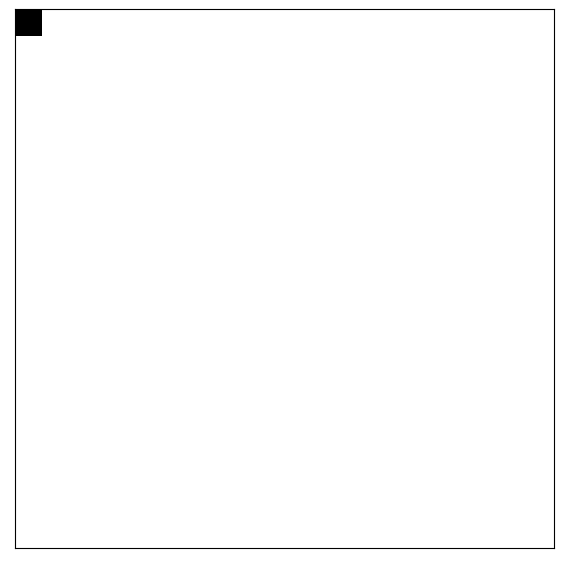

In [10]:
fig, axs = plt.subplots(figsize=(7, 7))
axs.set_xticks([])
axs.set_yticks([])
patch = plt.imshow(all_grid.iloc[0][0], cmap = plt.cm.binary)

def animate(i):
    patch.set_data(all_grid_iloc[i][0])
    
anim = animation.FuncAnimation(fig, animate, frames= MAX_ITERATIONS)

In [11]:
anim